In [2]:
!pip install ../input/efficientnetpytorch/efficientnet_pytorch-0.3.0-py3-none-any.whl

In [1]:
!nvidia-smi

Thu Jul 25 20:33:24 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   54C    P0   227W / 300W |  15435MiB / 16130MiB |     71%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
# Downloading: "http://storage.googleapis.com/public-models/efficientnet-b3-c8376fa2.pth" to /tmp/.cache/torch/checkpoints/efficientnet-b3-c8376fa2.pth
import os
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')

!cp ../input/efficientnetpytorch/*.pth /tmp/.cache/torch/checkpoints/

# params

In [3]:
SEED = 111

BS = 9
PERC_VAL = 0.2

MODEL_NAME = 'efficientnet-b5'
from efficientnet_pytorch import EfficientNet
SZ = EfficientNet.get_image_size(MODEL_NAME)
for i in range(6):
    print(f'efficientnet-b{i} size', EfficientNet.get_image_size(f'efficientnet-b{i}'))
print('SZ:', SZ)

from fastai.vision import *
params_tfms = {}


efficientnet-b0 size 224
efficientnet-b1 size 240
efficientnet-b2 size 260
efficientnet-b3 size 300
efficientnet-b4 size 380
efficientnet-b5 size 456
SZ: 456


## img proc

In [4]:
use_center_crop = True

> get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None) → Collection[Transform]

In [5]:
from fastai.vision import *
params_tfms = dict(
    max_rotate=0,
    max_zoom=1,
    max_warp=0,
    max_lighting=0.3,
)

> By default, the library resizes the image while keeping its original ratio so that the smaller size corresponds to the given size, then takes a crop (ResizeMethod.CROP). You can choose to resize the image while keeping its original ratio so that the bigger size corresponds to the given size, then take a pad (ResizeMethod.PAD). Another way is to just squish the image to the given size (ResizeMethod.SQUISH).

In [6]:
kwargs_tfms = dict(
    resize_method=ResizeMethod.SQUISH,
    padding_mode='zeros'
)

keep_less=0.83

# setup

In [7]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

## image processing

In [8]:
import cv2

def crop_margin(image, keep_less=0.83):
    
    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,gray = cv2.threshold(gray,10,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        #print('no contours!')
        flag = 0
        return image, flag
    cnt = max(contours, key=cv2.contourArea)
    ((x, y), r) = cv2.minEnclosingCircle(cnt)
    r = r*keep_less
    x = int(x); y = int(y); r = int(r)
    flag = 1
    #print(x,y,r)
    if r > 100:
        return output[0 + (y-r)*int(r<y):-1 + (y+r+1)*int(r<y),0 + (x-r)*int(r<x):-1 + (x+r+1)*int(r<x)], flag
    else:
        #print('none!')
        flag = 0
        return image,flag

    
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
# https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
def center_crop(img):        
    
    h0, w0 = 480, 640 #most common in test
    ratio = h0/w0 #most common in test
    height, width, _= img.shape
    new_width, new_height = width, math.ceil(width*ratio)

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

def load_ben_color(fn)->Image:
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = crop_image_from_gray(image)
    image, _ = crop_margin(image)

    if use_center_crop:
        image = center_crop(image)

    image = cv2.resize(image, (640, 480))#most common in test
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX=10) , -4 ,128)
    return image

def open_yz(fn, convert_mode, after_open)->Image:
    image = load_ben_color(fn)
    return Image(pil2tensor(image, np.float32).div_(255))
    
vision.data.open_image = open_yz

## set seed

In [10]:
def set_torch_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_torch_seed()

# pretraining using old data

## prep

In [13]:
img2grd = []

p = '../input/diabetic-retinopathy-detection'
pp = Path(p)

train=pd.read_csv(pp/'trainLabels.csv')
train=pd.read_csv(pp/'trainLabels.csv')
img2grd_diab_train=[(f'../input/diabetic-retinopathy-detection/train_images/{o[0]}.jpeg',o[1],'diab')  for o in train.values]
img2grd += img2grd_diab_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

test=pd.read_csv(pp/'retinopathy_solution.csv')
img2grd_diab_test=[(f'../input/diabetic-retinopathy-detection/test_images/{o[0]}.jpeg',o[1],'diab')  for o in test.values]
img2grd += img2grd_diab_test
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())


35126

[(0, 25810), (2, 5292), (1, 2443), (3, 873), (4, 708)]

88702

[(0, 65343), (2, 13153), (1, 6205), (3, 2087), (4, 1914)]

In [14]:
p = '../input/IDRID/B. Disease Grading'
pp = Path(p)

train=pd.read_csv(pp/'2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')
img2grd_idrid_train=[(f'../input/IDRID/B. Disease Grading/1. Original Images/a. Training Set/{o[0]}.jpg',o[1],'idrid')  for o in train.values]
img2grd += img2grd_idrid_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

test=pd.read_csv(pp/'2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv')
img2grd_idrid_test=[(f'../input/IDRID/B. Disease Grading/1. Original Images/b. Testing Set/{o[0]}.jpg',o[1],'idrid')  for o in test.values]
img2grd += img2grd_idrid_test
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

89115

[(0, 65477), (2, 13289), (1, 6225), (3, 2161), (4, 1963)]

89218

[(0, 65511), (2, 13321), (1, 6230), (3, 2180), (4, 1976)]

In [15]:
if not np.all([Path(o[0]).exists() for o in img2grd]): print('Some files are missing!!!')

In [16]:
df_ext = pd.DataFrame(img2grd)
df_ext.columns = ['fnm', 'target', 'src']
df_ext = df_ext.reset_index()
df_ext.shape

(89218, 4)

## select data2use

http://localhost:8888/notebooks/data/git/blnd/nbs/DevLookSubmDistr.ipynb#

    2    1050
    3     373
    0     321
    1     138
    4      46

In [17]:
t2c_perhaps = {2:    1050,
3:     373,
0:     321,
1:     138,
4:      46,}
{t:int(c*5) for t,c in t2c_perhaps.items()}

{2: 5250, 3: 1865, 0: 1605, 1: 690, 4: 230}

In [18]:
t2c_external = dict(df_ext.target.value_counts())
t2c_external

{0: 65511, 2: 13321, 1: 6230, 3: 2180, 4: 1976}

In [19]:
t2c_wanted = {2: 5300, 3: 1900, 0: 1700, 1: 700, 4: 300}

In [20]:
def sample_df_ext():
    idx2use = []
    for t,c_val in t2c_wanted.items():
        idx_t = np.where(df_ext.target==t)[0]
        idx_t_2use = np.random.choice(idx_t, c_val, replace=False)
        idx2use += list(idx_t_2use)
    return df_ext.iloc[idx2use]

In [21]:
set_torch_seed()
df_ext_sample = sample_df_ext()

In [22]:
df_ext_sample.target.value_counts()

2    5300
3    1900
0    1700
1     700
4     300
Name: target, dtype: int64

## val set

In [23]:
img2grd = []

p = '../input/aptos2019-blindness-detection'
pp = Path(p)
train = pd.read_csv(pp/'train.csv')
len_blnd = len(train)

img2grd_blnd = [(f'{p}/train_images/{o[0]}.png',o[1],'blnd')  for o in train.values]

img2grd += img2grd_blnd
display(len(img2grd))
cnt = Counter(o[1] for o in img2grd)
t2c_trn_has = dict(cnt)
display(cnt.most_common())
sm = sum(cnt.values())
display([(o[0], o[1]/sm) for o in cnt.most_common()])

3662

[(0, 1805), (2, 999), (1, 370), (4, 295), (3, 193)]

[(0, 0.4929000546149645),
 (2, 0.272801747678864),
 (1, 0.1010376843255052),
 (4, 0.08055707263790278),
 (3, 0.052703440742763515)]

In [24]:
if not np.all([Path(o[0]).exists() for o in img2grd]): print('Some files are missing!!!')

In [25]:
df_blnd = pd.DataFrame(img2grd)
df_blnd.columns = ['fnm', 'target', 'src']
df_blnd = df_blnd.reset_index()
df_blnd.shape

(3662, 4)

## dataset

In [26]:
%%time
tfms = get_transforms(**params_tfms)

def get_data_pretrn(sz=SZ, bs=BS):
    
    df_trn = sample_df_ext().copy()
    df_val = df_blnd
    df_trn['is_val'] = False
    df_val['is_val'] = True
    df_pretrn = pd.concat([df_trn, df_val],ignore_index=True)
    
    src = (ImageList.from_df(df=df_pretrn,path='./',cols='fnm') 
            .split_from_df(col='is_val') 
            .label_from_df(cols='target',  
                           label_cls=FloatList)
          )

    data = (src.transform(tfms, size=sz,
                         **kwargs_tfms
                         ) #Data augmentation
            .databunch(bs=bs) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data

set_torch_seed()
data = get_data_pretrn()

CPU times: user 12 s, sys: 987 ms, total: 13 s
Wall time: 12.8 s


In [36]:
# fn = df_ext.fnm.sample().values[0]
fn = "../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png"

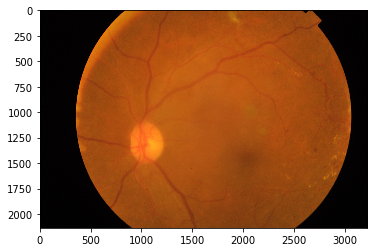

In [37]:
image = cv2.imread(fn)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

## compare

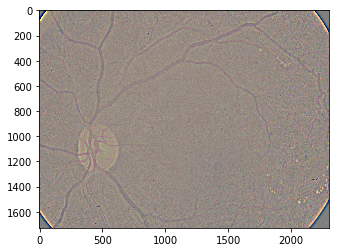

In [38]:
def load_ben_color(fn)->Image:
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = crop_image_from_gray(image)
    image, _ = crop_margin(image)

    if use_center_crop:
        image = center_crop(image)

#     image = cv2.resize(image, (640, 480))#most common in test
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX=10) , -4 ,128)
    return image

image = load_ben_color(fn)
plt.imshow(image)

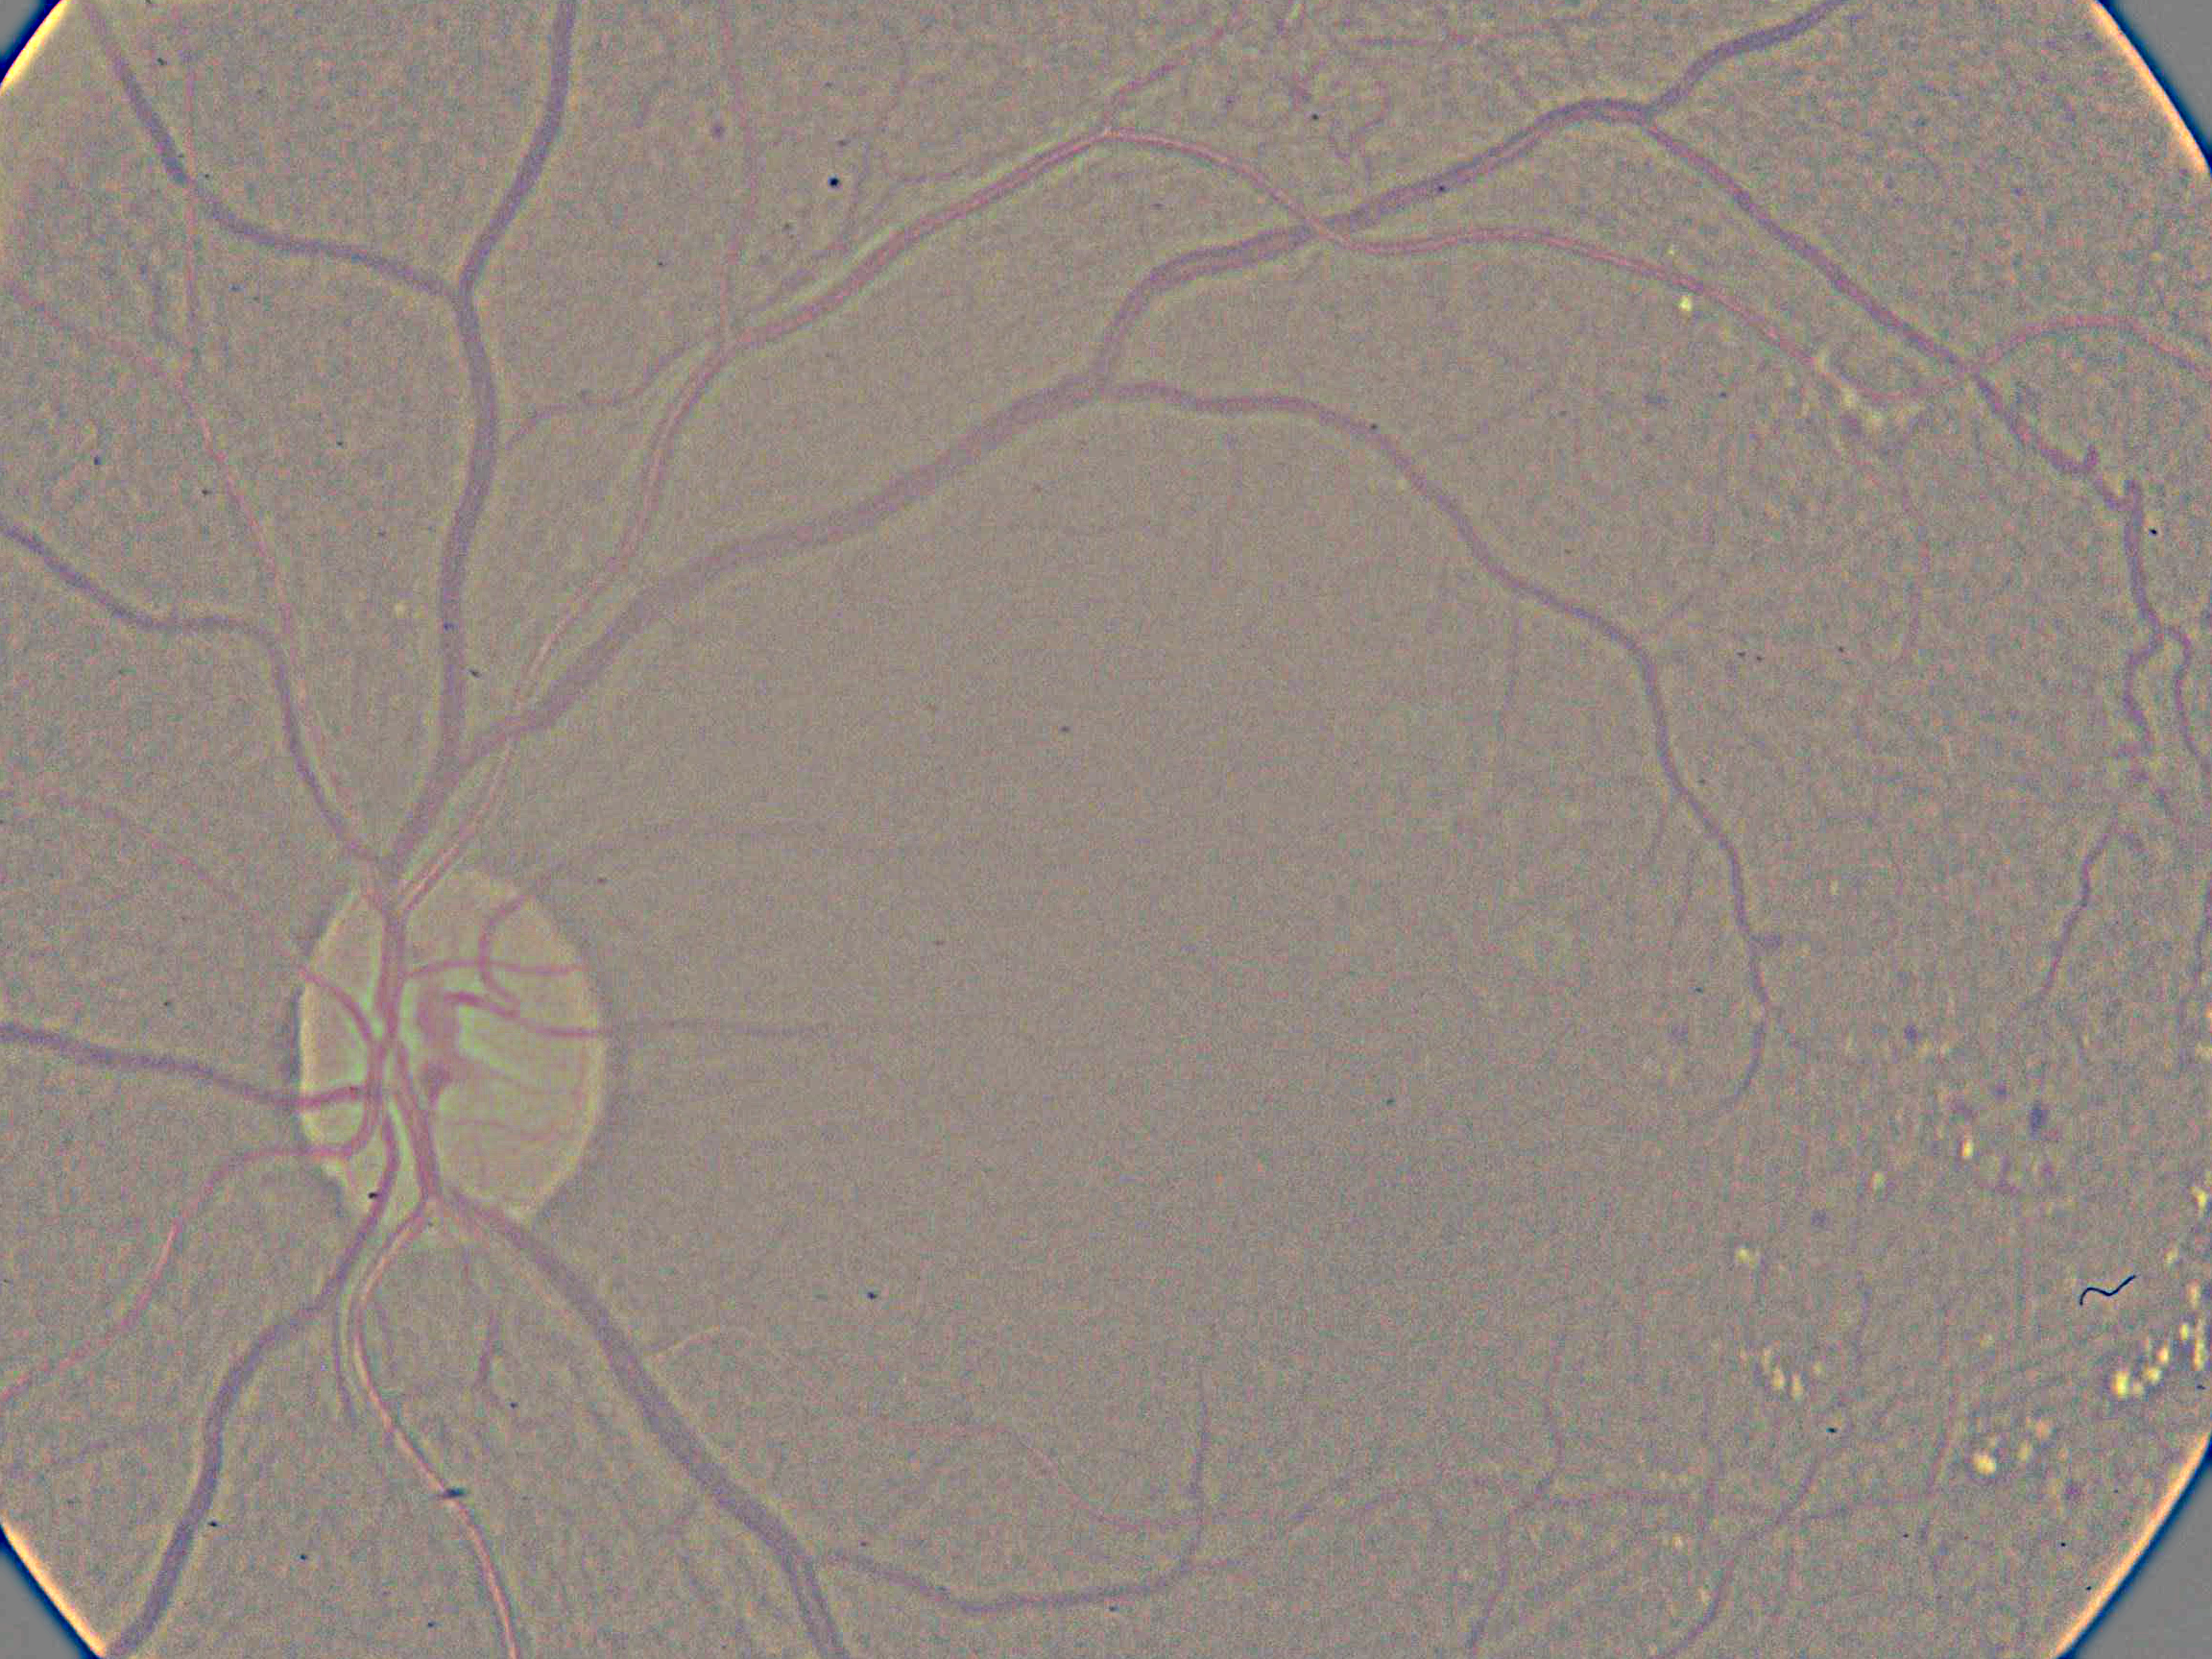

In [39]:
def open_yz(fn, convert_mode, after_open)->Image:
    image = load_ben_color(fn)
    return Image(pil2tensor(image, np.float32).div_(255))

open_yz(fn,None,None)

In [ ]:
%%time
vision.data.open_image = open_yz
data.show_batch(rows=3, figsize=(10, 10))

## compare

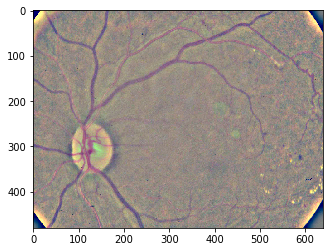

In [40]:
def load_ben_color(fn)->Image:
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = crop_image_from_gray(image)
    image, _ = crop_margin(image)

    if use_center_crop:
        image = center_crop(image)

    image = cv2.resize(image, (640, 480))#most common in test
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX=10) , -4 ,128)
    return image

image = load_ben_color(fn)
plt.imshow(image)

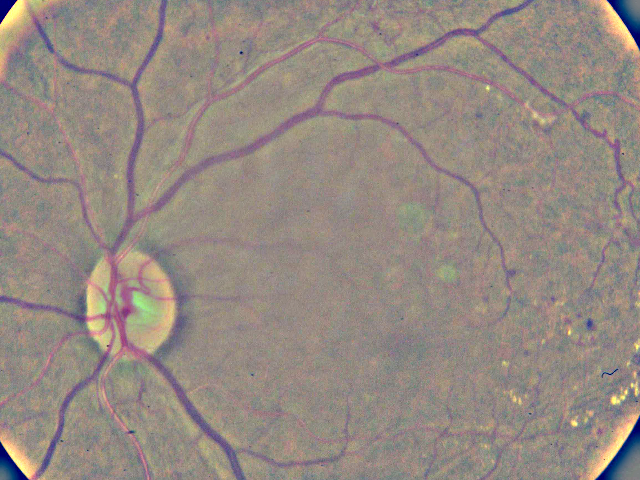

In [41]:
def open_yz(fn, convert_mode, after_open)->Image:
    image = load_ben_color(fn)
    return Image(pil2tensor(image, np.float32).div_(255))

open_yz(fn,None,None)

In [ ]:
%%time
vision.data.open_image = open_yz
data.show_batch(rows=3, figsize=(10, 10))

## compare

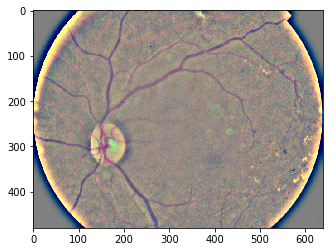

In [47]:
def load_ben_color(fn)->Image:
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)

    if use_center_crop:
        image = center_crop(image)

    image = cv2.resize(image, (640, 480))#most common in test
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX=10) , -4 ,128)
    return image

image = load_ben_color(fn)
plt.imshow(image)

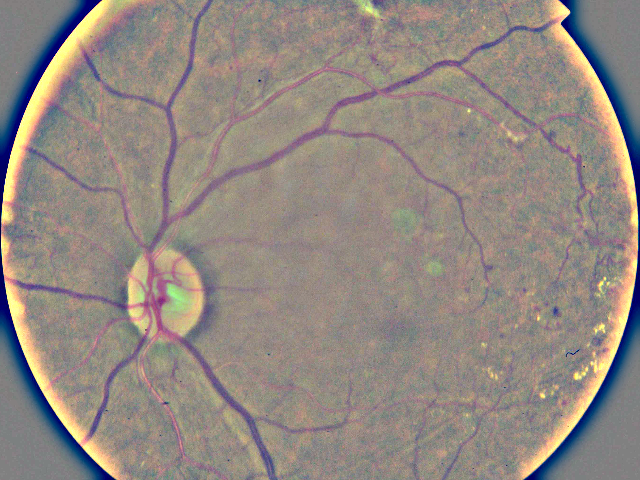

In [48]:
def open_yz(fn, convert_mode, after_open)->Image:
    image = load_ben_color(fn)
    return Image(pil2tensor(image, np.float32).div_(255))

open_yz(fn,None,None)

In [35]:
%%time
vision.data.open_image = open_yz
data.show_batch(rows=3, figsize=(10, 10))

RuntimeError: Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/pin_memory.py", line 41, in _pin_memory_loop
    batch = pin_memory_batch(batch)
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/pin_memory.py", line 58, in pin_memory_batch
    return [pin_memory_batch(sample) for sample in batch]
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/pin_memory.py", line 58, in <listcomp>
    return [pin_memory_batch(sample) for sample in batch]
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/pin_memory.py", line 50, in pin_memory_batch
    return batch.pin_memory()
RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1556653099582/work/aten/src/THC/THCCachingHostAllocator.cpp:265
